Saved: corr_predictors.csv, corr_heatmap.png


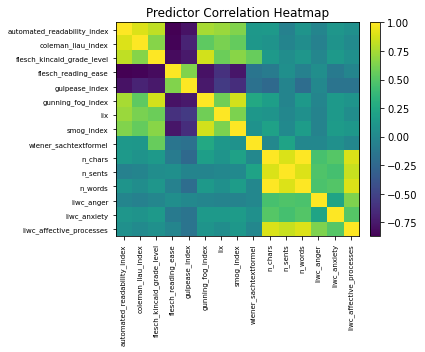

In [1]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt

FILES = [
    'anxiety_2024_features_tfidf_256.csv',
    'depression_2024_features_tfidf_256.csv',
    'suicidewatch_2024_features_tfidf_256.csv'
]
N_SAMPLE = 5000

READ = ['automated_readability_index','coleman_liau_index','flesch_kincaid_grade_level',
        'flesch_reading_ease','gulpease_index','gunning_fog_index','lix','smog_index','wiener_sachtextformel']
COUNT = ['n_chars','n_sents','n_words']
LIWC_AFFECT = ['liwc_anger','liwc_anxiety','liwc_affective_processes']  # 你数据中均存在

df = pd.concat([pd.read_csv(p, encoding='ISO-8859-1', low_memory=False) for p in FILES], ignore_index=True)
if N_SAMPLE: df = df.sample(N_SAMPLE, random_state=42)

USE = [c for c in READ+COUNT+LIWC_AFFECT if c in df.columns]
X = df[USE].apply(pd.to_numeric, errors='coerce')
X = X.dropna(axis=0, how='any')

corr = X.corr()
corr.to_csv('corr_predictors.csv')

plt.figure(figsize=(6,5))
im = plt.imshow(corr.values, aspect='auto')
plt.xticks(range(len(USE)), USE, rotation=90, fontsize=7)
plt.yticks(range(len(USE)), USE, fontsize=7)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Predictor Correlation Heatmap')
plt.tight_layout()
plt.savefig('corr_heatmap.png', dpi=600)
print('Saved: corr_predictors.csv, corr_heatmap.png')


Saved: pca_explained_variance.csv, pca_loadings.csv, pca_scree.png


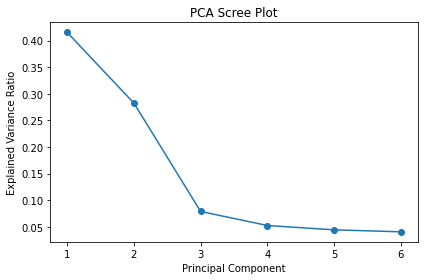

In [2]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

FILES = [
    'anxiety_2024_features_tfidf_256.csv',
    'depression_2024_features_tfidf_256.csv',
    'suicidewatch_2024_features_tfidf_256.csv'
]
N_SAMPLE = 5000

READ = ['automated_readability_index','coleman_liau_index','flesch_kincaid_grade_level',
        'flesch_reading_ease','gulpease_index','gunning_fog_index','lix','smog_index','wiener_sachtextformel']
COUNT = ['n_chars','n_sents','n_words']
LIWC_AFFECT = ['liwc_anger','liwc_anxiety','liwc_affective_processes']

df = pd.concat([pd.read_csv(p, encoding='ISO-8859-1', low_memory=False) for p in FILES], ignore_index=True)
if N_SAMPLE: df = df.sample(N_SAMPLE, random_state=42)
USE = [c for c in READ+COUNT+LIWC_AFFECT if c in df.columns]
X = df[USE].apply(pd.to_numeric, errors='coerce').dropna()

Z = StandardScaler().fit_transform(X)
pca = PCA(n_components=min(6, X.shape[1]), random_state=42).fit(Z)

explained = pd.Series(pca.explained_variance_ratio_, index=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=explained.index)

explained.to_csv('pca_explained_variance.csv')
loadings.to_csv('pca_loadings.csv')

plt.figure(figsize=(6,4))
plt.plot(range(1, pca.n_components_+1), explained.values, marker='o')
plt.xlabel('Principal Component'); plt.ylabel('Explained Variance Ratio'); plt.title('PCA Scree Plot')
plt.tight_layout(); plt.savefig('pca_scree.png', dpi=300)
print('Saved: pca_explained_variance.csv, pca_loadings.csv, pca_scree.png')


In [3]:

import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split

FILES = [
    'anxiety_2024_features_tfidf_256.csv',
    'depression_2024_features_tfidf_256.csv',
    'suicidewatch_2024_features_tfidf_256.csv'
]
N_SAMPLE = 5000
TARGET = 'liwc_negative_emotion'

READ = ['automated_readability_index','coleman_liau_index','flesch_kincaid_grade_level',
        'flesch_reading_ease','gulpease_index','gunning_fog_index','lix','smog_index','wiener_sachtextformel']
COUNT = ['n_chars','n_sents','n_words']
LIWC_AFFECT = ['liwc_anger','liwc_anxiety','liwc_affective_processes']

df = pd.concat([pd.read_csv(p, encoding='ISO-8859-1', low_memory=False) for p in FILES], ignore_index=True)
if N_SAMPLE: df = df.sample(N_SAMPLE, random_state=42)

def fit_block(feats, name):
    use = [c for c in feats if c in df.columns]
    data = df[use + [TARGET]].apply(pd.to_numeric, errors='coerce').dropna()
    X, y = data[use], data[TARGET]
    Z = StandardScaler().fit_transform(X)

    Xtr, Xte, ytr, yte = train_test_split(Z, y, test_size=0.3, random_state=42)
    # 速度优先：使用固定 alpha；若需严谨可做 CV（耗时）
    ridge = Ridge(alpha=1.0).fit(Xtr, ytr)
    lasso = Lasso(alpha=0.01, max_iter=3000).fit(Xtr, ytr)

    pd.Series(ridge.coef_, index=use, name=f'{name}_ridge_coef').to_csv(f'/mnt/data/{name}_ridge_coefs.csv')
    pd.Series(lasso.coef_, index=use, name=f'{name}_lasso_coef').to_csv(f'/mnt/data/{name}_lasso_coefs.csv')

    r2_r = ridge.score(Xte, yte); r2_l = lasso.score(Xte, yte)
    return {'family': name, 'n_features': len(use), 'ridge_R2': float(r2_r), 'lasso_R2': float(r2_l)}

blocks = {
    'all': READ + COUNT + LIWC_AFFECT,
    'readability': READ,
    'counts': COUNT,
    'liwc_affect': LIWC_AFFECT
}
perf = [fit_block(v, k) for k, v in blocks.items()]
pd.DataFrame(perf).to_csv('family_model_perf.csv', index=False)
print('Saved: *_coefs.csv, family_model_perf.csv')


Saved: *_coefs.csv, family_model_perf.csv
